# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import json
from SceneGraph3D.tools.load import load_3DSceneGraph
import bz2
import _pickle as cPickle
import math
import cv2
from PIL import Image as im
import skimage
import scipy
import pandas as pd
import openmesh as om

import sys
sys.path.append('./envs/utils')
from fmm_planner import FMMPlanner

In [2]:
map_resolution = 5
max_actions = 500
local_steps = 25
global_map_size = 480
num_sem_cats = 15
success_dist = 1
val_scenes = [ # these are all 1 floor
    'Collierville',
    'Darden',
    'Markleeville',
    'Wiconisco'
]
idx_to_name = {
    0: "chair",
    1: "couch",
    2: "potted plant",
    3: "bed",
    4: "toilet",
    5: "tv",
    6: "dining-table",
    7: "oven",
    8: "sink",
    9: "refrigerator",
    10: "book",
    11: "clock",
    12: "vase",
    13: "cup",
    14: "bottle"
}
name_to_idx = {name: idx for idx, name in idx_to_name.items()}

In [70]:
for ep in episodes_baseline:
    print(idx_to_name[ep["object_id"]], ep["spl"])

bed 0.0
toilet 0.8294080957529313
toilet 0.0
bed 1
chair 1
chair 0.9586401123653165
chair 1
chair 0.26985416785343364
toilet 0.1649438195463693
bed 0.24480588265002637
potted plant 0.0
couch 0.0
bed 0.15707145122408414
chair 1
chair 0.7755891163439265
couch 0.7922442046096866
chair 1
tv 0.0
tv 0.0
toilet 0.0
couch 0.0
toilet 0.16753387778896342
chair 0.36086894719030027
couch 0.6270086385195901
chair 0.6847075905209088
couch 1
toilet 0.0
toilet 0.0
potted plant 0.08276384688597077
couch 0.6295110999951683
potted plant 1
couch 0.0
couch 0.10264424110044353
potted plant 0.03329947758509941
potted plant 0.5909245197838934
bed 0.0
toilet 0.11801236868381493
tv 0.0
toilet 0.2508111741634333
toilet 0.27929808941836953
bed 0.0
couch 0.0
potted plant 0.21049590603451296
bed 0.7763786569251001
potted plant 0.13696327887532625
toilet 0.8767227658789936
tv 0.0
chair 1
couch 0.4834912062750728
couch 0.0
toilet 0.0
chair 0.8888494529913197
couch 0.0
toilet 0.0
toilet 0.0
toilet 0.27185255258865754


In [3]:
def parse_episodes(exp_name):
    with open('/Volumes/thesis/results_external/{}/val_episode_data.json'.format(exp_name), 'r') as f:
        episode_data = json.load(f)

    episode_ids = {}
    episodes = []
    for episode in episode_data:
        if len(episode["positions"])==0: continue
        scene = episode["scene_id"][16:-4]
        if scene not in episode_ids:
            episode_ids[scene] = set()
        if episode["episode_id"] not in episode_ids[scene]:
            episode_ids[scene].add(episode["episode_id"])
            episode["scene"] = scene
            episode["exp_name"] = exp_name
            episodes.append(episode)
    return episodes

In [4]:
episodes_baseline = parse_episodes("run200")
episodes_det = parse_episodes("deterministic")
episodes_baseline2 = parse_episodes("baseline_seed_2")

In [5]:
val_scenes = ['Collierville', 'Darden', 'Markleeville','Wiconisco']
scene_graphs = {}
for scene in val_scenes:
    scene_graphs[scene], _ = load_3DSceneGraph(scene, "verified_graph")

In [6]:
with bz2.BZ2File('data/datasets/objectnav/gibson/v1.1/val/val_info.pbz2', 'rb') as f:
    dataset_info = cPickle.load(f)

In [7]:
with open('scene_metadata.json', 'r') as f:
    all_scene_metadata = json.load(f)
scene_metadata = {}
for metadata in all_scene_metadata:
    if metadata["id"] in val_scenes:
        scene_metadata[metadata["id"]] = metadata

# Common

In [8]:
def distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

In [9]:
def get_episode(scene, episode_id, episodes):
    for episode in episodes:
        if episode["scene"]==scene and episode["episode_id"]==episode_id:
            return episode

In [10]:
def global_to_gt_map(mp, episode):
    global_start_rot = episode["positions"][0][2]
    gt_start_pos = episode["gt_positions"][0]
    gt_start_y, gt_start_x, gt_start_rot = gt_start_pos
    gt_start_rot = math.radians(gt_start_rot - global_start_rot)
    T1 = np.float32([[1, 0, -global_map_size//2], [0, 1, -global_map_size//2], [0, 0, 1]])
    R = np.float32([[math.cos(gt_start_rot), -math.sin(gt_start_rot), 0], [math.sin(gt_start_rot), math.cos(gt_start_rot), 0], [0, 0, 1]])
    T2 = np.float32([[1, 0, gt_start_x], [0, 1, gt_start_y], [0, 0, 1]])
    transform = T2 @ R @ T1
    rot_map = cv2.warpAffine(mp, transform[:2,:], mp.shape)
    return rot_map

In [ ]:
sem_map = dataset_info[scene][episode["floor_id"]]["sem_map"][0]
mp = np.load('maparr_{}_{}.npy'.format(scene, episode["episode_id"]))
rot_mp = global_to_gt_map(mp, episode)
sem_map_big = np.zeros_like(rot_mp)
sem_map_big[:sem_map.shape[0], :sem_map.shape[1]] = sem_map
plt.imshow(mp)
plt.show()
plt.imshow(rot_mp)
plt.show()
plt.imshow(sem_map_big)
plt.show()

In [11]:
def gt_to_global_map(mp, episode):
    global_start_rot = episode["positions"][0][2]
    gt_start_pos = episode["gt_positions"][0]
    gt_start_y, gt_start_x, gt_start_rot = gt_start_pos
    gt_start_rot = math.radians(gt_start_rot - global_start_rot)
    T1 = np.float32([[1, 0, -global_map_size//2], [0, 1, -global_map_size//2], [0, 0, 1]])
    R = np.float32([[math.cos(gt_start_rot), -math.sin(gt_start_rot), 0], [math.sin(gt_start_rot), math.cos(gt_start_rot), 0], [0, 0, 1]])
    T2 = np.float32([[1, 0, gt_start_x], [0, 1, gt_start_y], [0, 0, 1]])
    transform = np.linalg.inv(T2 @ R @ T1)
    rot_map = cv2.warpAffine(mp, transform[:2,:], (global_map_size, global_map_size))
    return rot_map

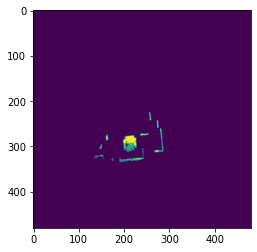

TypeError: Invalid shape (480, 480, 239) for image data

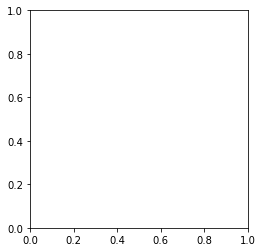

In [368]:
episode = get_episode("Collierville", 20, episodes_baseline)
gt_map = dataset_info[episode["scene"]][episode["floor_id"]]["sem_map"]
sem_map = np.load('/Volumes/thesis/results_external/{}/maparr_{}_{}.npy'.format(episode["exp_name"], episode["scene"], episode["episode_id"]))[0]
gt_rot = gt_to_global_map(gt_map, episode)
plt.imshow(sem_map)
plt.show()
plt.imshow(gt_rot)
plt.show()

In [12]:
def global_to_gt_point(x, y, episode):
    global_start_rot = episode["positions"][0][2]
    gt_start_pos = episode["gt_positions"][0]
    gt_start_y, gt_start_x, gt_start_rot = gt_start_pos
    gt_start_rot = math.radians(gt_start_rot - global_start_rot)
    gt_x, gt_y = x - global_map_size//2, y - global_map_size//2
    gt_x, gt_y = gt_x*math.cos(gt_start_rot) - gt_y*math.sin(gt_start_rot), \
        gt_x*math.sin(gt_start_rot) + gt_y*math.cos(gt_start_rot)
    gt_x, gt_y = gt_x + gt_start_x, gt_y + gt_start_y
    return gt_x, gt_y

In [ ]:
sem_map = dataset_info[scene][episode["floor_id"]]["sem_map"][0]
plt.imshow(sem_map)
positions = episode["positions"]
gt_positions = episode["gt_positions"]
for step in range(1, len(gt_positions)):
    plt.plot([gt_positions[step-1][1], gt_positions[step][1]], [gt_positions[step-1][0], gt_positions[step][0]], color="red")
    x1, y1 = global_to_gt_point(positions[step-1][1], positions[step-1][0], episode)
    x2, y2 = global_to_gt_point(positions[step][1], positions[step][0], episode)
    plt.plot([x1, x2], [y1, y2], color="blue")
plt.show()

In [387]:
def gt_to_sim(pt, origin):
    min_x, min_y = origin / 100.0
    sim_x = pt[0] / 20. + min_x
    sim_y = pt[1] / 20. + min_y
    return sim_x, sim_y

# Basic metrics

In [19]:
def compute_metrics(episodes):
    success, spl, dtg = 0, 0, 0
    for episode in episodes:
        success += episode["success"]/len(episodes)
        spl += episode["spl"]/len(episodes)
        dtg += episode["distance_to_goal"]/len(episodes)
    return success, spl, dtg

In [50]:
success, spl, dtg = compute_metrics(episodes)
print("Success rate:", success)
print("SPL:", spl)
print("DTG:", dtg)

Success rate: 0.6532663316582851
SPL: 0.32397327599189135
DTG: 1.4668575747173334


In [122]:
success, spl, dtg = compute_metrics(episodes_det)
print("Success rate:", success)
print("SPL:", spl)
print("DTG:", dtg)

Success rate: 0.6287499999999921
SPL: 0.31579415390755206
DTG: 1.4333516773797184


# Is success correlated with path statistics?

## Area coverage

In [11]:
success_areas = []
success_areas_norm = []
failure_areas = []
failure_areas_norm = []
for episode in episodes:
    area = episode["explored_area"] * (map_resolution/100)**2
    area_norm = area/scene_graphs[episode["scene"]].floor_area
    if episode["success"]:
        success_areas.append(area)
        success_areas_norm.append(area_norm)
    else:
        failure_areas.append(area)
        failure_areas_norm.append(area_norm)

In [12]:
mean_success_area, mean_success_area_norm = np.mean(success_areas), np.mean(success_areas_norm)
mean_failure_area, mean_failure_area_norm = np.mean(failure_areas), np.mean(failure_areas_norm)
print("Mean success area:", mean_success_area)
print("Mean failure area:", mean_failure_area)
print("Mean success area normalized:", mean_success_area_norm)
print("Mean failure area normalized:", mean_failure_area_norm)

Mean success area: 48.57238579911452
Mean failure area: 56.42872404402582
Mean success area normalized: 1.1887543303134822
Mean failure area normalized: 1.3166533817736237


(array([[ 31., 106., 109., 125.,  34.,  39.,  44.,  20.,   7.,   5.],
        [ 24.,  41.,  30.,  71.,  25.,  22.,  20.,  24.,   7.,  12.]]),
 array([  0.92464706,  14.73340697,  28.54216687,  42.35092677,
         56.15968668,  69.96844658,  83.77720648,  97.58596638,
        111.39472629, 125.20348619, 139.01224609]),
 <a list of 2 BarContainer objects>)

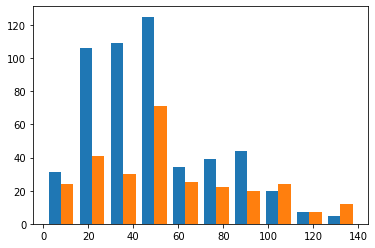

In [13]:
plt.hist((success_areas, failure_areas))

## Path length

In [14]:
success_lengths = []
success_lengths_norm = []
failure_lengths = []
failure_lengths_norm = []
for episode in episodes:
    length = 0
    for step in range(1, len(episode["positions"])):
        length += distance(episode["positions"][step-1], episode["positions"][step])
    length *= (map_resolution/100)
    length_norm = length/episode["shortest_dist"]
    if episode["success"]:
        success_lengths.append(length)
        success_lengths_norm.append(length_norm)
    else:
        failure_lengths.append(length)
        failure_lengths_norm.append(length_norm)

In [15]:
mean_success_length, mean_success_length_norm = np.mean(success_lengths), np.mean(success_lengths_norm)
mean_failure_length, mean_failure_length_norm = np.mean(failure_lengths), np.mean(failure_lengths_norm)
print("Mean success length:", mean_success_length)
print("Mean failure length:", mean_failure_length)
print("Mean success length normalized:", mean_success_length_norm)
print("Mean failure length normalized:", mean_failure_length_norm)

Mean success length: 14.459765733596383
Mean failure length: 25.914853971914415
Mean success length normalized: 4.28502371464054
Mean failure length normalized: 6.740474947030574


(array([[230., 136.,  68.,  46.,  17.,   8.,   6.,   6.,   3.,   0.],
        [ 87.,  59.,  38.,  21.,   9.,   9.,   8.,   8.,  27.,  10.]]),
 array([ 0.        ,  8.75415918, 17.50831835, 26.26247753, 35.0166367 ,
        43.77079588, 52.52495505, 61.27911423, 70.0332734 , 78.78743258,
        87.54159175]),
 <a list of 2 BarContainer objects>)

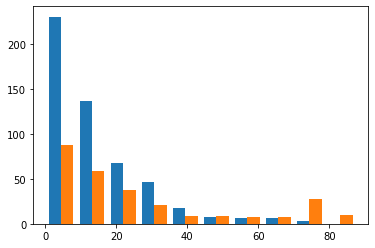

In [16]:
plt.hist((success_lengths, failure_lengths))

## Number of actions

In [17]:
success_actions = []
failure_actions = []
for episode in episodes:
    num_actions = len(episode["positions"])
    if episode["success"]:
        success_actions.append(num_actions)
    else:
        failure_actions.append(num_actions)

In [18]:
mean_success_action = np.mean(success_actions)
mean_failure_action = np.mean(failure_actions)
print("Mean success action:", mean_success_action)
print("Mean failure action:", mean_failure_action)

Mean success action: 107.77692307692308
Mean failure action: 258.84057971014494


In [19]:
action_limit_reached = np.sum(np.array(failure_actions) >= max_actions-1)
total_failures = len(failure_actions)
print("Total failures:", total_failures)
print("Action limit reached:", action_limit_reached)

Total failures: 276
Action limit reached: 109


# Is success correlated with object properties?

In [61]:
counts = {}
volumes = {}
for scene_graph in scene_graphs.values():
    for obj in scene_graph.object.values():
        if obj.class_ not in name_to_idx or name_to_idx[obj.class_] > 5: continue
        counts[obj.class_] = counts.get(obj.class_, 0) + 1
        volumes[obj.class_] = volumes.get(obj.class_, 0) + obj.volume
print("Counts")
for cls, count in counts.items():
    print(cls, count)
print()
print("Volumes")
for cls, vol in volumes.items():
    print(cls, vol/counts[cls])

Counts
toilet 15
chair 57
couch 9
potted plant 40
bed 10
tv 9

Volumes
toilet 0.11161626259928971
chair 0.2276887289751378
couch 1.108881714190405
potted plant 0.06080985867594688
bed 3.089507458588232
tv 0.062314079835678715


In [71]:
num_episodes = {}
succs = {}
spls = {}
dtgs = {}
for episode in episodes_baseline:
    num_episodes[episode["object_id"]] = num_episodes.get(episode["object_id"], 0) + 1
    succs[episode["object_id"]] = succs.get(episode["object_id"], 0) + episode["success"]
    spls[episode["object_id"]] = spls.get(episode["object_id"], 0) + episode["spl"]
    dtgs[episode["object_id"]] = dtgs.get(episode["object_id"], 0) + episode["distance_to_goal"]

for idx in num_episodes.keys():
    print(idx_to_name[idx], num_episodes[idx], succs[idx]/num_episodes[idx], spls[idx]/num_episodes[idx], dtgs[idx]/num_episodes[idx])

bed 85 0.29411764705882354 0.11936390115698334 3.455712634336499
toilet 176 0.6590909090909091 0.3043414506433853 2.23098441951767
chair 145 0.896551724137931 0.6359736553437987 0.4062841519099989
potted plant 162 0.8024691358024691 0.2270143983499866 0.6230007733044391
couch 189 0.5767195767195767 0.32395298761835506 1.2267569277912085
tv 39 0.2564102564102564 0.10136086052688902 2.2957797709352925


In [56]:
num_episodes

{}

# What role does the global policy play?

## Visualization

In [13]:
def render_episode(episode, map_type, render_goals=False, print_success=True):
        
    plt.figure(figsize=(6, 8)) 
    cmap = colors.ListedColormap(['white','gray','blue'])
        
    gt_sem_map = dataset_info[episode["scene"]][episode["floor_id"]]["sem_map"]
    if map_type=="gt":
        render_map = np.zeros_like(gt_sem_map[0])
        goal_map = gt_sem_map[episode["object_id"]+1].astype(int)
        trav_map = gt_sem_map[0].astype(int)
        render_map[trav_map==1] = 1
        render_map[goal_map==1] = 2
    elif map_type=="agent":
        sem_map = np.load('/Volumes/thesis/results_external/{}/maparr_{}_{}.npy'.format(episode["exp_name"], episode["scene"], episode["episode_id"]))
        render_map = np.zeros_like(sem_map[0])
        goal_map = sem_map[episode["object_id"]+4]
        trav_map = sem_map[0]
        render_map[trav_map>0] = 1
        render_map[goal_map>0] = 2
        render_map = global_to_gt_map(render_map, episode)[:gt_sem_map.shape[1], :gt_sem_map.shape[2]]
        if np.sum(goal_map)==0:
            cmap = colors.ListedColormap(['white','gray'])    
    plt.imshow(render_map, cmap=cmap)
    plt.xlim([render_map.shape[1]//2-260, render_map.shape[1]//2+260])
    plt.ylim([render_map.shape[0]//2+260, render_map.shape[0]//2-260])
    plt.xticks([])
    plt.yticks([])
    
    # plot trajectories
    prev_x, prev_y = global_to_gt_point(episode["positions"][0][1], episode["positions"][0][0], episode)
    for step in range(1, len(episode["positions"])):
        next_x, next_y = global_to_gt_point(episode["positions"][step][1], episode["positions"][step][0], episode)
        plt.plot([prev_x, next_x], [prev_y, next_y], color="red")
        prev_x, prev_y = next_x, next_y
    plt.scatter(prev_x, prev_y, marker="*", color="red", s=50)
    
    if render_goals and len(episode["policy_goals"]):
        prev_x, prev_y = global_to_gt_point(episode["policy_goals"][0][0][1], episode["policy_goals"][0][0][0], episode)
        for step in range(1, len(episode["policy_goals"])):
            next_x, next_y = global_to_gt_point(episode["policy_goals"][step][0][1], episode["policy_goals"][step][0][0], episode)
            plt.plot([prev_x, next_x], [prev_y, next_y], color="green")
            prev_x, prev_y = next_x, next_y
        plt.scatter(prev_x, prev_y, marker="*", color="green", s=50)
    
    plt.show()
    if episode["success"]:
        label = "Success"
    else:
        if episode["used_policy"][-1]:
            label = "Failure - Object not found"
        else:
            label = "Failure - Object found"
    if print_success: print(label)

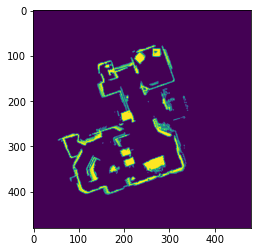

In [369]:
sem_map = np.load('/Volumes/thesis/results_external/{}/maparr_{}_{}.npy'.format('run200', "Wiconisco", 0))[0]
plt.imshow(sem_map)

In [370]:
gt_sem_map = dataset_info["Wiconisco"][0]["sem_map"][0]
print(np.unique(gt_sem_map))

[0. 1.]


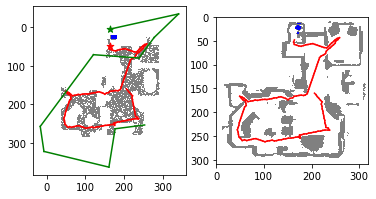

Success


In [318]:
episode = get_episode("Wiconisco", 0, episodes_baseline)
sem_map = render_episode(episode, "run200", render_goals=True)

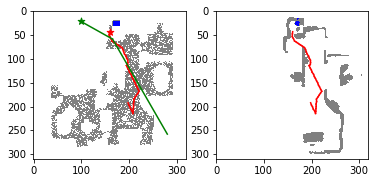

Success


In [133]:
episode = get_episode("Wiconisco", 23, episodes_det)
sem_map = render_episode(episode, "deterministic", render_goals=True)

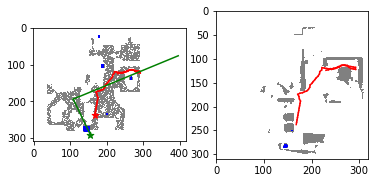

Failure - Object found


In [24]:
episode = get_episode("Wiconisco", 1)
sem_map = render_episode(episode, render_goals=True)

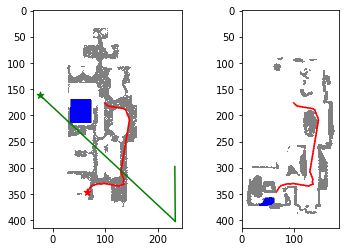

Failure - Object found


In [25]:
episode = get_episode("Darden", 10)
sem_map = render_episode(episode, render_goals=True)

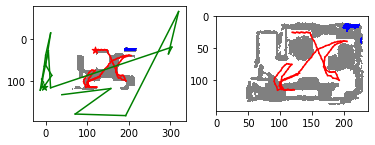

Failure - Object found


In [26]:
episode = get_episode("Collierville", 14)
sem_map = render_episode(episode, render_goals=True)

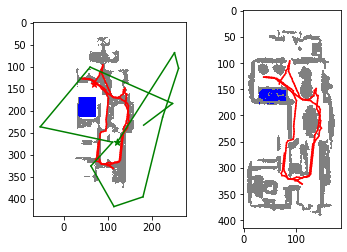

Failure - Object found


In [27]:
episode = get_episode("Darden", 84)
sem_map = render_episode(episode, render_goals=True)

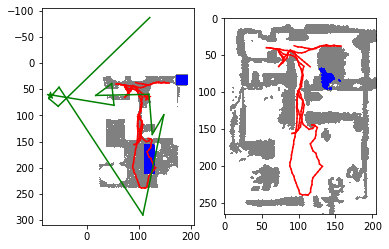

Failure - Object found


In [28]:
episode = get_episode("Markleeville", 73)
sem_map = render_episode(episode, render_goals=True)

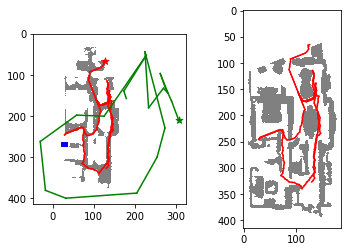

Failure - Object not found


In [29]:
episode = get_episode("Darden", 4)
sem_map = render_episode(episode, render_goals=True)

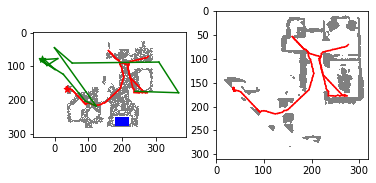

Failure - Object not found


In [30]:
episode = get_episode("Wiconisco", 71)
sem_map = render_episode(episode, render_goals=True)

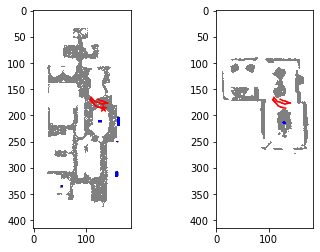

Failure - Object found


In [31]:
episode = get_episode("Darden", 61)
render_episode(episode)

In [ ]:
for i, ep in enumerate(episode_data):
    if ep["used_policy"][-1]:
        print(ep["scene_id"], ep["episode_id"])

## Are policy goals located near the the most co-occurring objects?

In [384]:
def traversible_dist_to_cats(pos, episode, cat_ids):
    sem_map = dataset_info[episode["scene"]][episode["floor_id"]]["sem_map"]
    origin = dataset_info[episode["scene"]][episode["floor_id"]]["origin"]
    x, y = gt_to_sim(pos, origin)
    selem = skimage.morphology.disk(2)
    traversible = skimage.morphology.binary_dilation(
        sem_map[0], selem) != True
    traversible = 1 - traversible
    planner = FMMPlanner(traversible)
    
    dists = np.zeros(len(cat_ids))
    for cat_id in cat_ids:
        if np.any(sem_map[cat_id+1]):
            cat_map = skimage.morphology.binary_dilation(sem_map[cat_id + 1], selem) != True
            cat_map = 1 - cat_map
            planner.set_multi_goal(cat_map)
            dists[cat_id] = planner.fmm_dist[int(pos[0]), int(pos[1])]/ 20.0
        else:
            dists[cat_id] = np.inf
        
    return dists

In [373]:
def construct_kdtrees(sem_map):
    trees = {}
    for cat in range(num_sem_cats):
        if np.any(sem_map[cat+1]):
            cat_coords = np.column_stack(sem_map[cat+1].nonzero()) # (y, x)
            trees[cat] = scipy.spatial.KDTree(cat_coords)
    return trees        

In [34]:
scene_trees = {}
for scene in val_scenes:
    sem_map = dataset_info[scene][0]["sem_map"] # decide whether to use gt or agent map
    scene_trees[scene] = construct_kdtrees(sem_map)

In [382]:
def goal_dists(episodes, method="straight"):
    all_dists = np.zeros((3, max_actions//local_steps-1))
    counts = np.zeros((3, max_actions//local_steps-1))
    for episode in episodes:
        global_goals = np.zeros((len(episode["policy_goals"]), 2))
        for i, goal in enumerate(episode["policy_goals"]):
            global_goals[i, 1], global_goals[i, 0] = global_to_gt_point(goal[0][1], goal[0][0], episode)
            
        if method=="straight":
            dists, _ = scene_trees[episode["scene"]][episode["object_id"]].query(global_goals)
        elif method=="traversible":
            dists = np.zeros(len(global_goals))
            for i in range(global_goals.shape[0]):
                dists[i] = traversible_dist_to_cats(global_goals[i], episode, [episode["object_id"]])
        
        if episode["success"]:
            r = 0
        else:
            if episode["used_policy"][-1]: # obj not found
                r = 1
            else:
                r = 2
        all_dists[r, :len(dists)] += dists / 20.
        counts[r, :len(dists)] += 1
    
    return all_dists, counts

In [376]:
all_dists, counts = goal_dists(episodes_baseline, "straight")

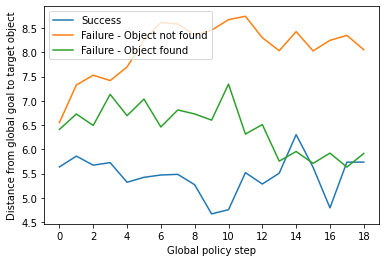

In [380]:
plt.plot(np.arange(max_actions//local_steps-1), all_dists[0]/counts[0], label="Success")
plt.plot(np.arange(max_actions//local_steps-1), all_dists[1]/counts[1], label="Failure - Object not found")
plt.plot(np.arange(max_actions//local_steps-1), all_dists[2]/counts[2], label="Failure - Object found")
plt.xticks(np.arange(0, max_actions//local_steps-1, 2))
plt.xlabel("Global policy step")
plt.ylabel("Distance from global goal to target object")
plt.legend()

In [385]:
all_dists, counts = goal_dists(episodes_baseline, "traversible")

IndexError: index 3 is out of bounds for axis 0 with size 1

In [388]:
nearest_counts = np.zeros((2, 6, num_sem_cats)) # only 6 cats are targets
for episode in episodes_baseline:
    global_goals = np.zeros((len(episode["policy_goals"]), 2))
    for i, goal in enumerate(episode["policy_goals"]):
        global_goals[i, 1], global_goals[i, 0] = global_to_gt_point(goal[0][1], goal[0][0], episode)
    
    all_dists = np.zeros((num_sem_cats, len(episode["policy_goals"])))
    for cat in range(num_sem_cats):
        if cat in scene_trees[episode["scene"]]:
            all_dists[cat, :], _ = scene_trees[episode["scene"]][cat].query(global_goals)
        else:
            all_dists[cat, :] = np.inf * np.ones(len(episode["policy_goals"]))
    
    nearest_cats = np.argmin(all_dists, axis=0)
    for nearest_cat in nearest_cats:
        nearest_counts[episode["success"]][episode["object_id"]][nearest_cat] += 1

all_nearest_cats = np.argsort(nearest_counts, axis=2)
top_nearest_cats = np.flip(all_nearest_cats[:, :, -3:], axis=2)
top_nearest_cats = np.concatenate((top_nearest_cats[0], top_nearest_cats[1]), axis=1)
top_nearest_cats = pd.DataFrame(top_nearest_cats)
top_nearest_cats = top_nearest_cats.apply(lambda x: x.map(idx_to_name))
#top_nearest_cats.iloc[0, :3] = "-" # these counts are 0
top_nearest_cats.index = top_nearest_cats.index.map(idx_to_name)
top_nearest_cats.columns = ["Failure 1st", "Failure 2nd", "Failure 3rd", "Success 1st", "Success 2nd", "Success 3rd"]
print(top_nearest_cats.to_string())

               Failure 1st   Failure 2nd   Failure 3rd Success 1st   Success 2nd   Success 3rd
chair         potted plant         couch          sink       chair  potted plant  refrigerator
couch                chair         couch        toilet       couch         chair  potted plant
potted plant         chair        toilet         couch       couch        toilet         chair
bed                  chair  potted plant         couch       chair  potted plant        toilet
toilet               chair         couch  potted plant       chair        toilet  potted plant
tv                  toilet         couch            tv      toilet          oven         couch


In [389]:
gt_nearest = np.zeros((6, num_sem_cats))
for scene in val_scenes:
    for obj in scene_graphs[scene].object.values():
        if obj.class_ not in name_to_idx: continue
        cat = name_to_idx[obj.class_]
        if cat > 5: continue
            
        min_dist = float('inf')
        min_class = None
        for other_obj in scene_graphs[scene].object.values():
            #if obj.parent_room != other_obj.parent_room: continue
            if obj == other_obj: continue
            if other_obj.class_ not in name_to_idx: continue
            dist = np.sum((obj.location - other_obj.location)**2)
            if dist < min_dist:
                min_dist = dist
                min_class = other_obj.class_
        gt_nearest[cat][name_to_idx[min_class]] += 1

top_gt_nearest = np.argsort(gt_nearest, axis=1)
top_gt_nearest = np.flip(top_gt_nearest[:, -3:], axis=1)
top_gt_nearest = pd.DataFrame(top_gt_nearest)
top_gt_nearest = top_gt_nearest.apply(lambda x: x.map(idx_to_name))
top_gt_nearest.index = top_gt_nearest.index.map(idx_to_name)
print(top_gt_nearest.to_string())

                         0             1             2
chair                chair          vase          book
couch                 book  potted plant           cup
potted plant  potted plant          vase          sink
bed           potted plant         couch        bottle
toilet              toilet          sink  potted plant
tv                      tv         chair          book


## Random policy ablation

In [313]:
episodes_baseline = parse_episodes("run200")
success, spl, dtg = compute_metrics(episodes_baseline)
print("Success rate:", success)
print("SPL:", spl)
print("DTG:", dtg)

Success rate: 0.6532663316582851
SPL: 0.32397327599189135
DTG: 1.4668575747173334


In [20]:
episodes_random_policy = parse_episodes("random_policy")
success, spl, dtg = compute_metrics(episodes_random_policy)
print("Success rate:", success)
print("SPL:", spl)
print("DTG:", dtg)

Success rate: 0.6658291457286366
SPL: 0.30581360420412124
DTG: 1.3677334704235802


In [21]:
episodes_random_policy2 = parse_episodes("random_policy_seed2")
success, spl, dtg = compute_metrics(episodes_random_policy2)
print("Success rate:", success)
print("SPL:", spl)
print("DTG:", dtg)

Success rate: 0.6231155778894414
SPL: 0.28803123635798444
DTG: 1.587522113213647


The random policy has slighly better SR and slightly worse SPL.

## Deterministic policy

The deterministic policy has slightly worse SR/SPL. Possible reason is looping as seen in image,
but analysis of exploration reward contradicts this.

In [319]:
episodes_det = parse_episodes("deterministic")
success, spl, dtg = compute_metrics(episodes_det)
print("Success rate:", success)
print("SPL:", spl)
print("DTG:", dtg)

Success rate: 0.6319095477386875
SPL: 0.3173810592035703
DTG: 1.4176200891309445


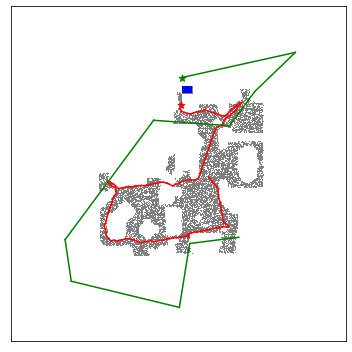

In [426]:
episode = get_episode("Wiconisco", 0, episodes_baseline)
sem_map = render_episode(episode, "gt", render_goals=True, print_success=False)

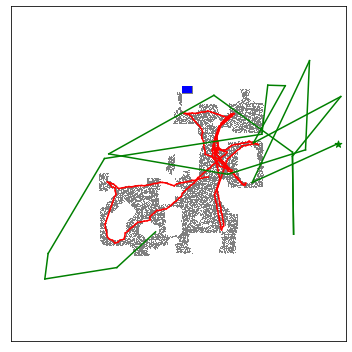

In [427]:
episode = get_episode("Wiconisco", 0, episodes_det)
sem_map = render_episode(episode, "gt", render_goals=True, print_success=False)

([<matplotlib.axis.XTick at 0x7fe466d2e3a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

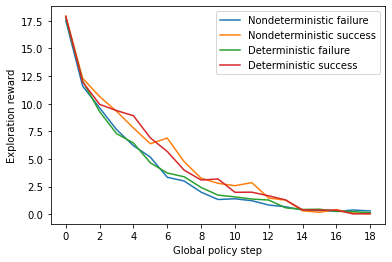

In [17]:
all_rews = np.zeros((2, max_actions//local_steps-1))
counts = np.zeros((2, max_actions//local_steps-1))
for episode in episodes_baseline:
    all_rews[episode["success"], :len(episode["explore_rewards"])] += np.array(episode["explore_rewards"])
    counts[episode["success"], :len(episode["explore_rewards"])] += 1
plt.plot(np.arange(all_rews.shape[1]), all_rews[0]/counts[0], label="Nondeterministic failure")
plt.plot(np.arange(all_rews.shape[1]), all_rews[1]/counts[1], label="Nondeterministic success")

all_rews = np.zeros((2, max_actions//local_steps))
counts = np.zeros((2, max_actions//local_steps))
for episode in episodes_det:
    all_rews[episode["success"], :len(episode["explore_rewards"])] += np.array(episode["explore_rewards"])
    counts[episode["success"], :len(episode["explore_rewards"])] += 1
plt.plot(np.arange(all_rews.shape[1]-1), all_rews[0,1:]/counts[0,1:], label="Deterministic failure")
plt.plot(np.arange(all_rews.shape[1]-1), all_rews[1,1:]/counts[1,1:], label="Deterministic success")

plt.xlabel("Global policy step")
plt.ylabel("Exploration reward")
plt.legend()
plt.xticks(np.arange(0, all_rews.shape[1]-1, 2))

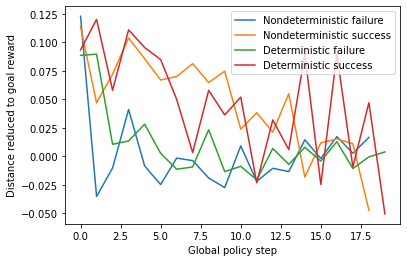

In [336]:
all_rews = np.zeros((2, max_actions//local_steps-1))
counts = np.zeros((2, max_actions//local_steps-1))
for episode in episodes_baseline:
    all_rews[episode["success"], :len(episode["goal_rewards"])] += np.array(episode["goal_rewards"])
    counts[episode["success"], :len(episode["goal_rewards"])] += 1
plt.plot(np.arange(all_rews.shape[1]), all_rews[0]/counts[0], label="Nondeterministic failure")
plt.plot(np.arange(all_rews.shape[1]), all_rews[1]/counts[1], label="Nondeterministic success")

all_rews = np.zeros((2, max_actions//local_steps))
counts = np.zeros((2, max_actions//local_steps))
for episode in episodes_det:
    all_rews[episode["success"], :len(episode["goal_rewards"])] += np.array(episode["goal_rewards"])
    counts[episode["success"], :len(episode["goal_rewards"])] += 1
plt.plot(np.arange(all_rews.shape[1]), all_rews[0]/counts[0], label="Deterministic failure")
plt.plot(np.arange(all_rews.shape[1]), all_rews[1]/counts[1], label="Deterministic success")

plt.xlabel("Global policy step")
plt.ylabel("Distance reduced to goal reward")
plt.legend()

## Shuffle episodes

In [63]:
shuffled_episodes = parse_episodes("shuffle")
success, spl, dtg = compute_metrics(shuffled_episodes)
print("Success rate:", success)
print("SPL:", spl)
print("DTG:", dtg)

Success rate: 0.6620603015075311
SPL: 0.3282057366182555
DTG: 1.4995217677423416


In [ ]:
suc_to_fail, fail_to_suc, total_common = 0, 0, 0
for ep in episodes:
    for shuffled_ep in shuffled_episodes:
        if ep["scene"] == shuffled_ep["scene"] and ep["episode_id"] == shuffled_ep["episode_id"]:
            total_common += 1
            if ep["success"] and not shuffled_ep["success"]:
                suc_to_fail += 1
                print(ep["scene"], shuffled_ep["episode_id"])
            elif not ep["success"] and shuffled_ep["success"]:
                fail_to_suc += 1

print("Common episodes:", total_common)
print("Success to failure:", suc_to_fail)
print("Failure to success:", fail_to_suc)

# Failure mode analysis

## Premature stopping (semantic failure)

In [47]:
def get_semantic_clusters(sem_map):
    sem_map_bin = (sem_map > 0)
    labels = skimage.measure.label(sem_map_bin)
    regions = skimage.measure.regionprops(labels, sem_map)
    #conf = np.take(sem_map, np.ravel_multi_index((region.coords[:,0], region.coords[:,1]), sem_map.shape))
    return regions

In [76]:
episode = get_episode("Wiconisco", 10, episodes)
sem_map = np.load('results/{}/maparr_{}_{}.npy'.format(exp_name, episode["scene"], episode["episode_id"]))[episode["object_id"]+4]
regions = get_semantic_clusters(sem_map)
print(regions)
#sem_map = dataset_info[episode["scene"]][0]["sem_map"][episode["object_id"]+1]

Wiconisco 1 is a good example for showing how the higher confidence region is the gt object, but the agent fails by stopping at the lower confidence region.

In [307]:
def stopping_analysis(episodes):
    num_highest_conf = np.zeros(2)
    conf = np.zeros(2)
    conf_all = [[], []]
    totals = np.zeros(2)
    for episode in episodes:
        # only consider episodes where agent found object and emitted stop action
        if not episode["success"] and len(episode["positions"]) >= max_actions-1: continue

        # get target regions
        sem_map = np.load('/Volumes/thesis/results_external/{}/maparr_{}_{}.npy'.format(episode["exp_name"], episode["scene"], episode["episode_id"]))[episode["object_id"]+4]
        regions = get_semantic_clusters(sem_map)
        end_position = episode["positions"][-1][:2]

        # amongst target regions within success distance, find one with highest confidence
        highest_conf_success_region = None
        highest_conf_success = 0
        min_dist = np.inf
        for region in regions:
            for coord in region.coords:
                dist = distance(coord, end_position)/20
                min_dist = min(min_dist, dist)
                if dist < success_dist:
                    if region.intensity_mean > highest_conf_success:
                        highest_conf_success = region.intensity_mean
                        highest_conf_success_region = region
                    break
        if not highest_conf_success_region:
            print(episode["scene"], episode["episode_id"], min_dist, episode["success"])
            continue
            
        # check if there are any further regions with higher confidence
        stop_highest_conf = True
        for region in regions:
            if region is highest_conf_success_region: continue
            if highest_conf_success_region.intensity_mean < region.intensity_mean:
                stop_highest_conf = False
                break

        totals[episode["success"]] += 1
        conf[episode["success"]] += highest_conf_success_region.intensity_mean
        conf_all[episode["success"]].append(highest_conf_success_region.intensity_mean)
        if stop_highest_conf:
            num_highest_conf[episode["success"]] += 1
        
    print()
    print("# Failures (stop emitted):", totals[0])
    print("# Successes (stop emitted):", totals[1])
    print("# Failures - stopped near highest confidence cluster:", num_highest_conf[0]/totals[0])
    print("# Successes - stopped near highest confidence cluster:", num_highest_conf[1]/totals[1])
    print("Failure avg confidence:", conf[0]/totals[0])
    print("Success avg confidence:", conf[1]/totals[1])

    plt.hist((conf_all[0], conf_all[1]))

Collierville 7 inf 1
Collierville 26 inf 1
Collierville 46 inf 1
Darden 61 1.2747548783981961 0
Collierville 67 inf 1
Wiconisco 82 4.55 0
Darden 92 inf 0
Collierville 79 1.7564168070250297 1
Darden 99 2.470323865407125 0
Darden 101 2.6172504656604803 0
Collierville 99 inf 1
Collierville 110 inf 1
Darden 144 inf 0
Markleeville 139 inf 1
Collierville 160 inf 1
Darden 192 1.6007810593582121 0
Markleeville 171 inf 1
Collierville 196 inf 1

# Failures (stop emitted): 160.0
# Successes (stop emitted): 509.0
# Failures - stopped near highest confidence cluster: 0.70625
# Successes - stopped near highest confidence cluster: 0.9096267190569745
Failure avg confidence: 0.28240155735984446
Success avg confidence: 0.34881909918415127


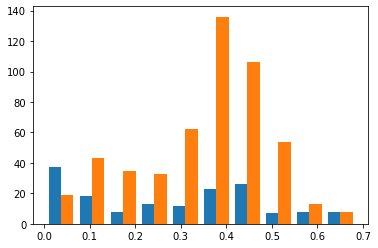

In [308]:
episodes = parse_episodes('run200')
stopping_analysis(episodes)

## Planner semantic map thresholding

[0.6532663316582851, 0.6557788944723554, 0.6721105527638124, 0.6545226130653202, 0.6545226130653202]


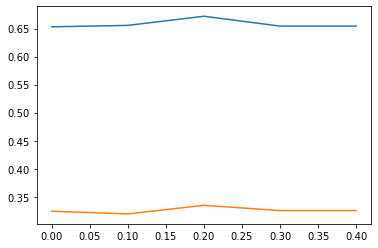

In [303]:
successes, spls, dtgs = [], [], []
for exp_name in ['run200', 'sem_thr_1', 'sem_thr_2', 'sem_thr_3', 'sem_thr_4']:
    episodes = parse_episodes(exp_name)
    success, spl, dtg = compute_metrics(episodes)
    successes.append(success)
    spls.append(spl)
    dtgs.append(dtg)

thrs = [0, 0.1, 0.2, 0.3, 0.4]
plt.plot(thrs, successes)
plt.plot(thrs, spls)
#plt.plot(thrs, dtgs)
plt.show()

Collierville 7 inf 1
Collierville 26 inf 1
Markleeville 31 inf 1
Collierville 37 1.0606601717798214 1
Collierville 41 inf 1
Collierville 46 inf 1
Wiconisco 63 1.1884864324004714 1
Collierville 61 inf 1
Collierville 62 inf 1
Collierville 64 inf 1
Collierville 67 inf 1
Collierville 82 inf 1
Collierville 110 inf 1
Collierville 130 inf 1
Markleeville 171 inf 1
Markleeville 172 inf 1
Wiconisco 170 4.1800119617053735 1
Collierville 160 inf 1
Collierville 163 inf 1
Wiconisco 177 8.50779054749234 1
Collierville 192 inf 1
Collierville 197 inf 1

# Failures (stop emitted): 135.0
# Successes (stop emitted): 513.0
# Failures - stopped near highest confidence cluster: 0.8444444444444444
# Successes - stopped near highest confidence cluster: 0.9200779727095516
Failure avg confidence: 0.3416472195199242
Success avg confidence: 0.36114473975686534


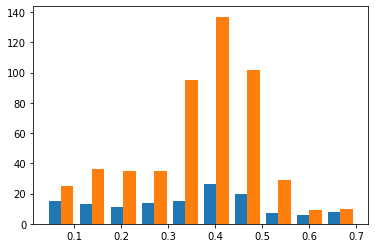

In [309]:
episodes_sem_thr_2 = parse_episodes('sem_thr_2')
stopping_analysis(episodes_sem_thr_2)

Takeaways:
- Small gain in SR/SPL
- Failure mode shifted towards max actions reached
- Agent stops near highest conf cluster more frequently (but cluster still in wrong place)
- Stop cluster has same conf in success and failure cases
- Train with this hyperparameter?

In [347]:
ct = 0
episodes = parse_episodes('random_policy')
for ep in episodes:
    if len(ep["positions"])>=max_actions-1:
        ct += ep["success"]
print(ct)

28


# Room-level analysis

In [220]:
def render_room_seg(scene):
    sem_map = dataset_info[scene][0]["sem_map"][0]
    map_obj_origin = dataset_info[scene][0]['origin']
    min_x, min_y = map_obj_origin / 100.0
    fig, ax = plt.subplots()
    cmap = colors.ListedColormap(['white','gray'])
    ax.imshow(sem_map, cmap=cmap)
    
    for room in scene_graphs[scene].room.values():
        print(room.location)
        if room.floor_number=="B":
            center = int((-room.location[1] - min_x) * 20), int((room.location[0] - min_y) * 20)
            #plt.scatter(center[1], center[0])
            radius = np.sqrt(room.floor_area/math.pi)*20
            circle = plt.Circle(center, radius, color='r')
            ax.add_patch(circle)

[ 2.220425  4.408125 -1.422608]
[0.640608 4.5504   1.163166]
[-0.207275   0.998075   1.1634125]
[ 2.1274255  2.37719   -1.553546 ]
[7.78137  4.782415 1.149824]
[-0.37271    4.5057    -1.4078765]
[-0.234195   0.152835  -1.4098315]
[-1.0960845  5.12565    1.159992 ]
[ 7.11811   4.424515 -1.434244]
[3.99202  4.780105 1.149334]
[ 6.59043  0.66634 -1.42038]
[5.46294   0.82251   1.1315925]
[ 2.75952  0.16919 -0.12695]
[ 3.97461   4.44873  -1.427056]


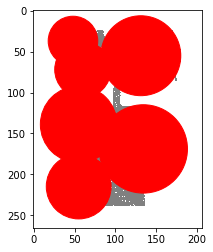

In [221]:
render_room_seg("Markleeville")

In [ ]:
mesh = om.read_trimesh('/Volumes/thesis/gibson_tiny/Markleeville/mesh.obj')

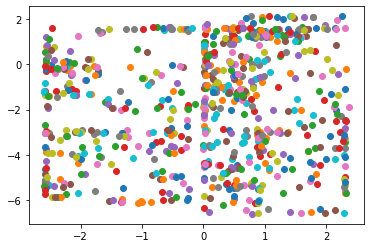

In [259]:
sem_map = dataset_info["Markleeville"][0]["sem_map"][0]
map_obj_origin = dataset_info["Markleeville"][0]['origin']
min_x, min_y = map_obj_origin / 100.0
#plt.imshow(sem_map)
for i in range(0, len(mesh.points()), 1000):
    pt = mesh.points()[i]
    #pt_gt = int((-pt[1] - min_x) * 20), int((pt[0] - min_y) * 20)
    plt.scatter(pt[1], pt[2])
plt.show()

# Scene-level analysis

In [39]:
scene_metrics = {}
for episode in episodes_baseline:
    scene = episode["scene"]
    if scene not in scene_metrics: 
        scene_metrics[scene] = {}
    scene_metrics[scene]['total'] = scene_metrics[scene].get('total', 0) + 1
    scene_metrics[scene]['success'] = scene_metrics[scene].get('success', 0) + episode["success"]
    scene_metrics[scene]['spl'] = scene_metrics[scene].get('spl', 0) + episode["spl"]

for scene in scene_metrics:
    scene_metrics[scene]['success'] /= scene_metrics[scene]['total']
    scene_metrics[scene]['spl'] /= scene_metrics[scene]['total']
    scene_metrics[scene]['area'] = scene_graphs[scene].floor_area # may not accurate bc we only have one floor; also diff from the one in scene_metadata
    scene_metrics[scene]['rooms'] = scene_graphs[scene].num_rooms
    scene_metrics[scene]['objects'] = scene_graphs[scene].num_objects
    scene_metrics[scene]['nav_complexity'] = scene_metadata[scene]['stats']['navigation_complexity']
    scene_metrics[scene]['ssa'] = scene_metadata[scene]['stats']['ssa']

scene_metrics = pd.DataFrame(scene_metrics)
print(scene_metrics.to_string())

                    Darden  Collierville   Wiconisco  Markleeville
total           197.000000    200.000000  199.000000    200.000000
success           0.538071      0.765000    0.708543      0.600000
spl               0.258613      0.396926    0.358655      0.280892
area             50.219645     28.947550   50.874839     39.954871
rooms            28.000000     14.000000   25.000000     14.000000
objects          68.000000     43.000000   62.000000     50.000000
nav_complexity    7.162000      3.944000    6.327000      5.198000
ssa               1.515000      1.203000    1.827000      0.955000


# What is the distribution of failure modes?

## Failure cases: object found vs not found

In [22]:
seen_dtg = []
not_seen_dtg = []
for episode in episodes_baseline:
    if not episode["success"]:
        if not episode["used_policy"][-1]:
            seen_dtg.append(episode["distance_to_goal"])
        else:
            not_seen_dtg.append(episode["distance_to_goal"])

num_seen_fails, mean_dtg_seen = len(seen_dtg), np.mean(seen_dtg)
num_not_seen_fails, mean_dtg_not_seen = len(not_seen_dtg), np.mean(not_seen_dtg)
print("Number failures when object seen:", num_seen_fails)
print("DTG when object seen:", mean_dtg_seen)
print("Number failures when object not seen (max actions reached):", num_not_seen_fails)
print("DTG when object not seen:", mean_dtg_not_seen)

Number failures when object seen: 186
DTG when object seen: 3.252870272980376
Number failures when object not seen (max actions reached): 90
DTG when object not seen: 6.250941763340512


## Object not found cases: semantic detection errors vs exploration errors

Out of the ~100 failures in which target obj not in agent map, most are cases where the gt object was seen but
did not make it into the correct semantic channel.

In [26]:
def exp_or_sem_failure(episode, exp_thr):
    gt_target_map = dataset_info[episode["scene"]][episode["floor_id"]]["sem_map"][episode["object_id"]+1]
    gt_target_map = (gt_target_map > 0)
    
    agent_exp_map = np.load('/Volumes/thesis/results_external/{}/maparr_{}_{}.npy'.format( \
                    'run200', episode["scene"], episode["episode_id"]))[1]
    agent_exp_map = global_to_gt_map(agent_exp_map, episode)
    agent_exp_map = agent_exp_map[:gt_target_map.shape[0], :gt_target_map.shape[1]]
    agent_exp_map = (agent_exp_map > exp_thr)
    
    if np.any(np.logical_and(agent_exp_map, gt_target_map)):
        return "semantic"
    else:
        return "exploration"

In [28]:
episodes_baseline = parse_episodes('run200')
thrs = np.arange(10)/10.
sem_fails = np.zeros(10)
exp_fails = np.zeros(10)
for i, exp_thr in enumerate(thrs):
    for episode in episodes_baseline:
        if not episode["success"] and episode["used_policy"][-1]: # target not in sem map
            if exp_or_sem_failure(episode, exp_thr) == "semantic":
                sem_fails[i] += 1
            else:
                exp_fails[i] += 1

print(sem_fails)
print(exp_fails)

[64. 61. 60. 58. 56. 56. 56. 55. 55. 55.]
[26. 29. 30. 32. 34. 34. 34. 35. 35. 35.]


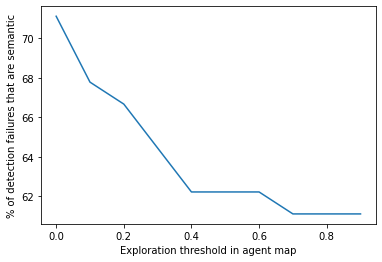

In [29]:
plt.plot(thrs, 100*sem_fails/(sem_fails + exp_fails))
plt.xlabel("Exploration threshold in agent map")
plt.ylabel("% of detection failures that are semantic")
plt.show()

In [32]:
episodes_baseline = parse_episodes('run200')
scene_outs = {scene: {"succ": 0, "stop": 0, "sem": 0, "exp":0} for scene in val_scenes}
class_outs = {target_id: {"succ": 0, "stop": 0, "sem": 0, "exp":0} for target_id in range(6)}
for episode in episodes_baseline:
    if episode["success"]:
        scene_outs[episode["scene"]]["succ"] += 1
        class_outs[episode["object_id"]]["succ"] += 1
    else:
        if episode["used_policy"][-1]: # target not in sem map
            if exp_or_sem_failure(episode, 0) == "semantic":
                scene_outs[episode["scene"]]["sem"] += 1
                class_outs[episode["object_id"]]["sem"] += 1
            else:
                scene_outs[episode["scene"]]["exp"] += 1
                class_outs[episode["object_id"]]["exp"] += 1
        else:
            scene_outs[episode["scene"]]["stop"] += 1
            class_outs[episode["object_id"]]["stop"] += 1
print(scene_outs)
print(class_outs)

{'Collierville': {'succ': 153, 'stop': 33, 'sem': 13, 'exp': 1}, 'Darden': {'succ': 106, 'stop': 67, 'sem': 11, 'exp': 13}, 'Markleeville': {'succ': 120, 'stop': 53, 'sem': 21, 'exp': 6}, 'Wiconisco': {'succ': 141, 'stop': 33, 'sem': 19, 'exp': 6}}
{0: {'succ': 130, 'stop': 13, 'sem': 2, 'exp': 0}, 1: {'succ': 109, 'stop': 60, 'sem': 19, 'exp': 1}, 2: {'succ': 130, 'stop': 14, 'sem': 16, 'exp': 2}, 3: {'succ': 25, 'stop': 47, 'sem': 9, 'exp': 4}, 4: {'succ': 116, 'stop': 25, 'sem': 17, 'exp': 18}, 5: {'succ': 10, 'stop': 27, 'sem': 1, 'exp': 1}}


In [38]:
for scene, counts in scene_outs.items():
    print(scene)
    for mode, count in counts.items():
        print(mode, count/sum(counts.values()))
    print()

print("Overall")
counts = np.zeros(4)
for count in scene_outs.values():
    counts += np.array(list(count.values()))
print(counts/np.sum(counts))

Collierville
succ 0.765
stop 0.165
sem 0.065
exp 0.005

Darden
succ 0.5380710659898477
stop 0.3401015228426396
sem 0.05583756345177665
exp 0.06598984771573604

Markleeville
succ 0.6
stop 0.265
sem 0.105
exp 0.03

Wiconisco
succ 0.7085427135678392
stop 0.1658291457286432
sem 0.09547738693467336
exp 0.03015075376884422

Overall
[0.65326633 0.23366834 0.08040201 0.03266332]


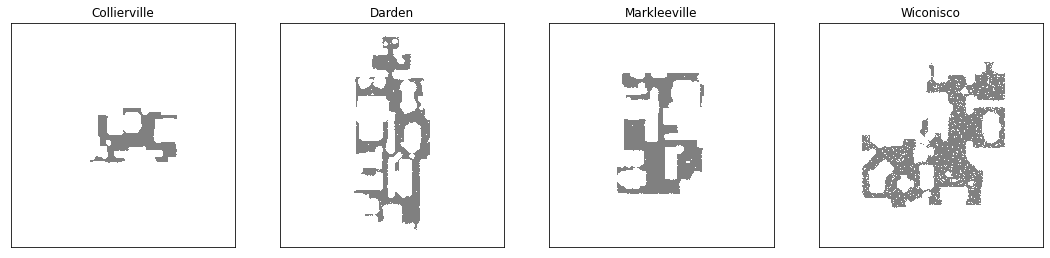

In [50]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(18.5, 10.5)
cmap = colors.ListedColormap(['white','gray'])  
for i, scene in enumerate(val_scenes):
    gt_map = dataset_info[scene][0]["sem_map"][0]
    axes[i].imshow(gt_map, cmap=cmap)
    axes[i].set_xlim([gt_map.shape[1]//2-200, gt_map.shape[1]//2+200])
    axes[i].set_ylim([gt_map.shape[0]//2+200, gt_map.shape[0]//2-200])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(scene)

In [51]:
for idx, counts in class_outs.items():
    print(idx_to_name[idx])
    for mode, count in counts.items():
        print(mode, count/sum(counts.values()))
    print()

print("Overall")
counts = np.zeros(4)
for count in class_outs.values():
    counts += np.array(list(count.values()))
print(counts/np.sum(counts))

chair
succ 0.896551724137931
stop 0.0896551724137931
sem 0.013793103448275862
exp 0.0

couch
succ 0.5767195767195767
stop 0.31746031746031744
sem 0.10052910052910052
exp 0.005291005291005291

potted plant
succ 0.8024691358024691
stop 0.08641975308641975
sem 0.09876543209876543
exp 0.012345679012345678

bed
succ 0.29411764705882354
stop 0.5529411764705883
sem 0.10588235294117647
exp 0.047058823529411764

toilet
succ 0.6590909090909091
stop 0.14204545454545456
sem 0.09659090909090909
exp 0.10227272727272728

tv
succ 0.2564102564102564
stop 0.6923076923076923
sem 0.02564102564102564
exp 0.02564102564102564

Overall
[0.65326633 0.23366834 0.08040201 0.03266332]
